# PXD012477
## Proteomic analyses of urine for healty ageing study

[PRIDE link](https://www.ebi.ac.uk/pride/archive/projects/PXD012477)

[Article link](https://link.springer.com/article/10.1007/s11357-020-00269-y)

In [1]:
#Import libraries
os.chdir("/home/robbe/ionbot/")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import numpy as np
import os
from pathlib import Path
from pyteomics import mass as pymass
import OxiAnalysis as OA
import importlib
importlib.reload(OA)
import warnings; warnings.simplefilter('ignore')

# Analysis without LFQ data

In [2]:
first = pd.read_csv('/home/robbe/ionbot/full_projects_/PXD012477/PXD012477_first.csv')
first.head()

,Unnamed: 0,ionbot_match_id,spectrum_title,scan,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,...,Organism,Cell line,Oxidant treatment,Oxidant dose (µM),Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting
0,0,0_4121_1,controllerType=0 controllerNumber=1 scan=10001,10001,1DLC0080815QE_RRAG_001_rep1,879.42991,879.43378,2170.70418,2,LDGSVDFK,...,Human,Urine,Healthy Ageing,0,None,0,0,0,NaN,First
1,1,0_4122_1,controllerType=0 controllerNumber=1 scan=10002,10002,1DLC0080815QE_RRAG_001_rep1,1177.60447,1176.60599,2170.83888,2,EITALAPSTMK,...,Human,Urine,Healthy Ageing,0,None,0,0,0,NaN,First
2,2,0_4123_2,controllerType=0 controllerNumber=1 scan=10003,10003,1DLC0080815QE_RRAG_001_rep1,986.50168,985.50146,2170.97352,2,IPACIAGER,...,Human,Urine,Healthy Ageing,0,None,0,0,0,NaN,First
3,3,0_4126_2,controllerType=0 controllerNumber=1 scan=10007,10007,1DLC0080815QE_RRAG_001_rep1,844.44016,844.44428,2171.58480,2,FPETVPR,...,Human,Urine,Healthy Ageing,0,None,0,0,0,NaN,First
4,4,0_4128_1,controllerType=0 controllerNumber=1 scan=10011,10011,1DLC0080815QE_RRAG_001_rep1,1791.87363,1791.88240,2172.40680,2,VPEPCPSTVTPAPAQQK,...,Human,Urine,Healthy Ageing,0,None,0,0,0,NaN,First


In [3]:
del first["Unnamed: 0"]
del first["spectrum_title"]
del first["scan"]
first['modifications'] = first['modifications'].fillna("None")
first['Oxidant treatment'] = first['Oxidant treatment'].fillna("None")
first['Secondary treatment'] = first['Secondary treatment'].fillna("None")
first['Length of Secondary treatment (mins)'] = first['Length of Secondary treatment (mins)'].fillna(0)
first['Length of oxidant treatment (mins)'] = first['Length of oxidant treatment (mins)'].replace('0', 0)

In [4]:
print("The amount of PSMs in this project dataset is: ", first.shape[0])
print("The amount of raw files that make up the master dataset is: ", len(first["spectrum_file"].unique()))

The amount of PSMs in this project dataset is:  5795500
The amount of raw files that make up the master dataset is:  489


In [5]:
first['Peptidoform_name'] = first.apply(lambda row: OA.peptidoform_name(row), axis=1)
first['Position'] = first['modifications'].apply(OA.get_positions)
first['Modification'] = first['modifications'].apply(OA.get_modification)
first['Oxidatively_modified'] = first['modifications'].apply(OA.oxidatively_modified)

## Overview of the treatments in this project

In [6]:
first.groupby(["Oxidant treatment", "Oxidant dose (µM)", "Length of oxidant treatment (mins)", "Secondary treatment", "Secondary treatment dose (µM)", 'Length of Secondary treatment (mins)'])["ionbot_match_id"].count().to_frame().reset_index()

,Oxidant treatment,Oxidant dose (µM),Length of oxidant treatment (mins),Secondary treatment,Secondary treatment dose (µM),Length of Secondary treatment (mins),ionbot_match_id
0,Healthy Ageing,0,0,None,0,0,2736885
1,Non-Healthy Ageing,0,0,None,0,0,3058615


In [ ]:
H = first.loc[lambda first: first["Oxidant treatment"] == "Healthy Ageing"]
NH = first.loc[lambda first: first["Oxidant treatment"] == "Non-Healthy Ageing"]

In [ ]:
print("There are this many replicates of Healthy Ageing treatment: {}".format(H["spectrum_file"].nunique()))
print("There are this many replicates of Non-Healthy Ageing treatment: {}".format(NH["spectrum_file"].nunique()))

There are this many replicates of Healthy Ageing treatment: 234
There are this many replicates of Non-Healthy Ageing treatment: 255


In [ ]:
Hrep = OA.replicate_filter(H, 117)
NHrep = OA.replicate_filter(NH, 128)

### Oxidatively modified PSMs

In [ ]:
print("The ratio of PSMs that contain an oxidative modification in the Healthy Ageing treatment subset: {}".format((Hrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the Non-Healthy Ageing treatment subset: {}".format((NHrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))

The ratio of PSMs that contain an oxidative modification in the Healthy Ageing treatment subset: 7.934462589859209 %
The ratio of PSMs that contain an oxidative modification in the Non-Healthy Ageing treatment subset: 9.153490894450684 %


In [ ]:
mrHrep = OA.modratios(Hrep)
mrNHrep = OA.modratios(NHrep)

In [ ]:
modr = pd.merge(mrNHrep, mrHrep, on="Modification", suffixes=('_NH', '_H'))
modr["Difference"] = modr["Ratios_NH"] - modr["Ratios_H"]
modr = modr.drop(modr[(modr["Ratios_NH"] == 0) | (modr["Ratios_H"] == 0)].index)


,Modification,Ratios_NH,Ratios_H,Difference
0,[35]Oxidation[T],0.001096,0.000577,5.190632e-04
1,[35]Oxidation[E],0.001596,0.000947,6.486166e-04
2,[35]Oxidation[S],0.000490,0.000162,3.285756e-04
3,[35]Oxidation[Q],0.000598,0.000505,9.334245e-05
5,[35]Oxidation[I],0.001327,0.000746,5.809340e-04
...,...,...,...,...
119,[1918]Carbonyl[A],0.000003,0.000004,-3.846466e-07
120,[1918]Carbonyl[V],0.000014,0.000007,7.725674e-06
121,[1922]Pro->HAVA[P],0.000353,0.000279,7.400231e-05
124,[1925]Delta:O(4)[W],0.004591,0.005787,-1.195137e-03


In [ ]:
modr[modr['Modification'] == "[937]dichlorination[Y]"]

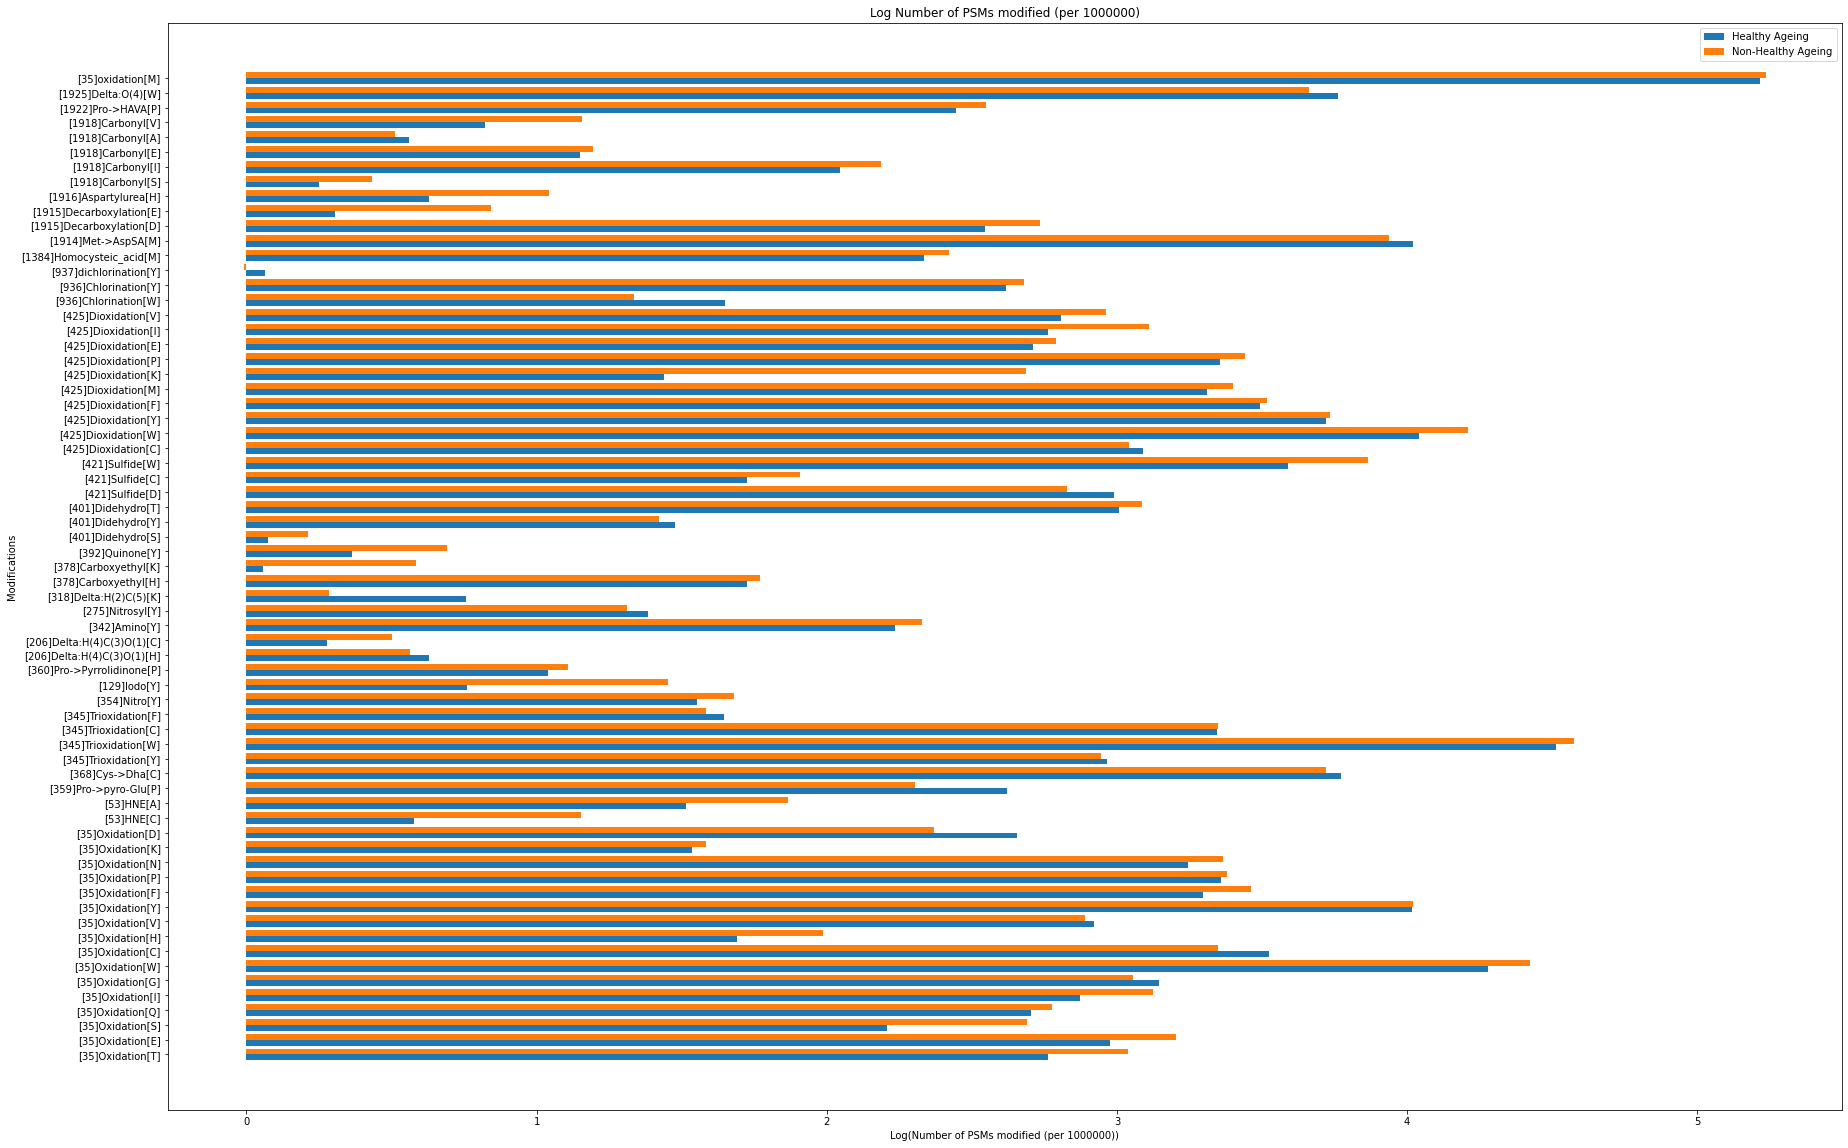

In [ ]:
y = modr["Modification"]
xnone = np.log10(modr['Ratios_H']*1000000)
xH = np.log10(modr['Ratios_NH']*1000000)
y_axis = np.arange(len(y))

plt.figure(figsize=(30,20))
plt.barh(y_axis - 0.2, xnone, 0.4, label = 'Healthy Ageing')
plt.barh(y_axis + 0.2, xH, 0.4, label = 'Non-Healthy Ageing')

plt.yticks(y_axis, y)
plt.ylabel("Modifications")
plt.xlabel("Log(Number of PSMs modified (per 1000000))")
plt.title("Log Number of PSMs modified (per 1000000)")

plt.legend()
plt.show()

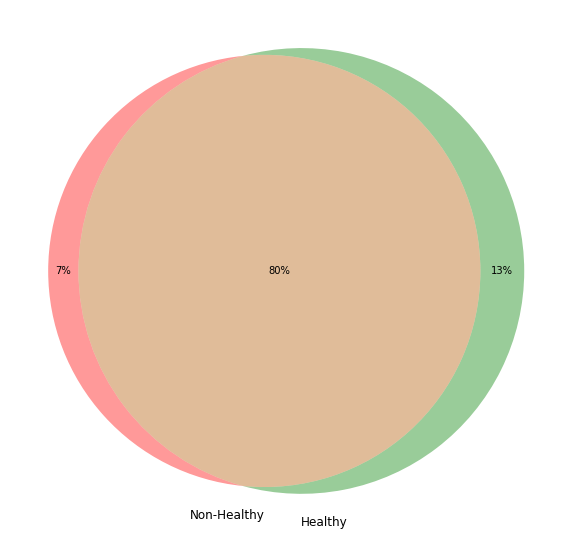

In [ ]:
OA.condition_venn([NHrep,Hrep], ["Non-Healthy", "Healthy"])

In [ ]:
difflist, pf_only_treatment = OA.comparelist(NHrep, Hrep)
pf_only_treatment.head()

,ionbot_match_id,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,matched_peptide,modifications,modifications_delta,...,Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting,Peptidoform_name,Position,Modification,Oxidatively_modified
22364,0_4091_1,1DLC0080815QE_RRAG_002_rep1,1124.56150,11245.6479,2192.88918,2,KASYIDCIR,KASYIDCIR,7|[4]carbamidomethyl[C],7|57.0215,...,None,0,0,0,NaN,First,KASYIDC[4]carbamidomethylIR,7,[4]carbamidomethyl[C],False
22425,0_4213_2,1DLC0080815QE_RRAG_002_rep1,1124.56077,11245.6479,2214.10302,2,KASYIDCIR,KASYIDCIR,7|[4]carbamidomethyl[C],7|57.0215,...,None,0,0,0,NaN,First,KASYIDC[4]carbamidomethylIR,7,[4]carbamidomethyl[C],False
22530,0_4466_1,1DLC0080815QE_RRAG_002_rep1,1159.48191,11594.8555,2269.33242,2,SDVMYTDWK,SDVMYTDWK,4|[35]oxidation[M],4|15.9949,...,None,0,0,0,NaN,First,SDVM[35]oxidationYTDWK,4,[35]oxidation[M],True
22570,0_4562_1,1DLC0080815QE_RRAG_002_rep1,1159.48130,11594.8555,2290.76466,2,SDVMYTDWK,SDVMYTDWK,4|[35]oxidation[M],4|15.9949,...,None,0,0,0,NaN,First,SDVM[35]oxidationYTDWK,4,[35]oxidation[M],True
22578,0_4579_1,1DLC0080815QE_RRAG_002_rep1,1995.90633,19959.2208,2293.89780,3,NECFIQHKDDNPNIPR,NECFIQHKDDNPNIPR,3|[4]carbamidomethyl[C],3|57.0215,...,None,0,0,0,NaN,First,NEC[4]carbamidomethylFIQHKDDNPNIPR,3,[4]carbamidomethyl[C],False


In [ ]:
onlytreatment = OA.modcounts(pf_only_treatment)
onlytreatment = onlytreatment.sort_values("Counts", ascending=False).drop(onlytreatment[onlytreatment["Counts"] == 0].index, axis=0)
onlytreatment

,Modification,Counts
129,[35]oxidation[M],6497
8,[35]Oxidation[W],2982
32,[345]Trioxidation[W],2035
85,[425]Dioxidation[I],1925
15,[35]Oxidation[F],1303
77,[425]Dioxidation[W],1128
5,[35]Oxidation[I],1125
74,[421]Sulfide[W],1101
1,[35]Oxidation[E],856
0,[35]Oxidation[T],807


In [ ]:
RPMH = OA.relative_PSM_modification(Hrep)
RPMNH = OA.relative_PSM_modification(NHrep)

In [ ]:
RPM = pd.merge(RPMH,RPMNH, on="Amino acid", suffixes=('_H', '_NH'))
RPM

,Amino acid,Relative level of PSMs containing unmodified residue_H,Relative level of PSMs containing unmodified residue_NH
0,A,0.997788,0.998003
1,R,0.999596,0.999512
2,N,0.970901,0.974015
3,D,0.994760,0.995557
4,C,0.032009,0.030566
5,Q,0.994747,0.994759
6,E,0.994192,0.992131
7,G,0.998093,0.998627
8,H,0.985067,0.979621
9,I,0.997205,0.994451


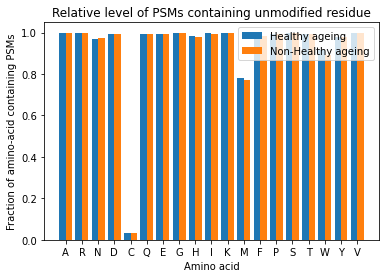

In [ ]:
x = RPM["Amino acid"]
xnone = RPM["Relative level of PSMs containing unmodified residue_H"]
xH = RPM['Relative level of PSMs containing unmodified residue_NH']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, xnone, 0.4, label = 'Healthy ageing')
plt.bar(x_axis + 0.2, xH, 0.4, label = 'Non-Healthy ageing')

plt.xticks(x_axis, x)
plt.xlabel("Amino acid")
plt.ylabel("Fraction of amino-acid containing PSMs")
plt.title("Relative level of PSMs containing unmodified residue")
plt.rcParams["figure.figsize"] = (8,8)
plt.legend()
plt.show()

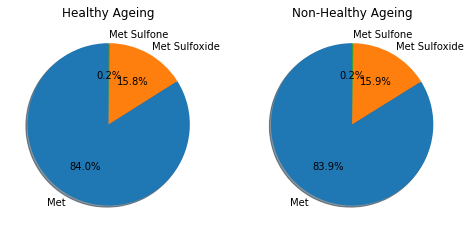

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
OA.methionine_overview(Hrep, ax1)
OA.methionine_overview(NHrep, ax2)
plt.title("Methionine containing peptides")
ax1.set_title("Healthy Ageing")
ax2.set_title("Non-Healthy Ageing")
plt.show()

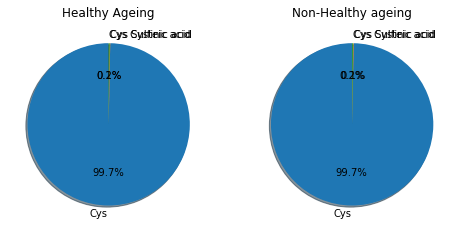

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
OA.cysteine_overview(Hrep, ax1)
OA.cysteine_overview(NHrep, ax2)
plt.title("cysteine containing peptides")
ax1.set_title("Healthy Ageing")
ax2.set_title("Non-Healthy ageing")
plt.show()

In [ ]:
importlib.reload(OA)
diffox, statement = OA.differentially_oxidized_psms(NHrep, Hrep)
with open("diffoxPXD012477.txt", "w") as f:
    for i in diffox:
        f.write(i)
        f.write("\n")
f.close()

In [ ]:
NHrep[(NHrep["Peptidoform_name"] == "NYISQYSEIAIQMMMHMQPK") & (NHrep["Oxidatively_modified"] == True)]

,ionbot_match_id,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,matched_peptide,modifications,modifications_delta,...,Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting,Peptidoform_name,Position,Modification,Oxidatively_modified
2280942,0_26953_1,1DLC071515QE_RRAG_062B_rep2,2474.09675,24421.2036,6514.881,2,NYISQYSEIAIQMMMHMQPK,NYISQYSEIAIQMMMHMQPK,x|[425]Dioxidation[M],0|,...,None,0,0,0,NaN,First,NYISQYSEIAIQMMMHMQPK,x,[425]Dioxidation[M],True


# Quantitative-based analysis

In [3]:
#quant = pd.read_csv("/home/robbe/ionbot/PXD012477/raw_files/QuantifiedPeptides.tsv", sep= "\t")
quant = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD012477/flashlfq_results/QuantifiedPeptides.tsv", sep="\t")
quant.drop(list(quant.filter(regex = 'Detection Type')), axis = 1, inplace = True)
quant.head()

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_1DLC0080815QE_RRAG_001_rep1,Intensity_1DLC0080815QE_RRAG_001_rep2,Intensity_1DLC120314QE_RRAG_001_rep1,Intensity_1DLC120314QE_RRAG_001_rep2,Intensity_1DLC012615QE_RRAG_001B_rep1,...,Intensity_1DLC012615QE_RRAG_008B_rep4,Intensity_1DLC120914QE_RRAG_009_rep1,Intensity_1DLC120914QE_RRAG_009_rep2,Intensity_1DLC120914QE_RRAG_009_rep3,Intensity_1DLC120914QE_RRAG_009_rep4,Intensity_1DLC012615QE_RRAG_009B_rep1,Intensity_1DLC012615QE_RRAG_009B_rep2,Intensity_1DLC012615QE_RRAG_009B_rep3,Intensity_1DLC012615QE_RRAG_009B_rep4,Unnamed: 983
0,AAAAAAAAAAAAAAAASAGGKx|[1927]Delta:H(4)C(5)O(1...,AAAAAAAAAAAAAAAASAGGK,NaN,NaN,NaN,0.0,0.0,138225.983265,132484.074364,164815.085379,...,84877.380967,11178.165559,50411.293713,0.000000,0.000000,11447.805538,0.0,8570.250729,0.000000,NaN
1,AAAAAAAAAKNGSSGKnan,AAAAAAAAAKNGSSGK,NaN,NaN,NaN,0.0,0.0,59682.551616,33086.921842,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN
2,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.0,0.0,185776.556271,21026.774331,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN
3,AAAAAAAAGAFAGRR7|[1918]Carbonyl[A],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN
4,AAAAAAAAQMHAKx|[205]Delta:H(6)C(6)O(1)[K],AAAAAAAAQMHAK,NaN,NaN,NaN,0.0,0.0,27244.860745,22892.768392,317624.729897,...,202659.820247,26194.228624,0.000000,121790.360066,26474.929387,61698.145139,0.0,0.000000,17235.695643,NaN


In [4]:
cols =[]
for i in quant.columns[5:-1]:
    cols.append(i)


In [5]:
OA.quantile_transform(quant, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_1DLC0080815QE_RRAG_001_rep1,Intensity_1DLC0080815QE_RRAG_001_rep2,Intensity_1DLC120314QE_RRAG_001_rep1,Intensity_1DLC120314QE_RRAG_001_rep2,Intensity_1DLC012615QE_RRAG_001B_rep1,...,Intensity_1DLC012615QE_RRAG_008B_rep4,Intensity_1DLC120914QE_RRAG_009_rep1,Intensity_1DLC120914QE_RRAG_009_rep2,Intensity_1DLC120914QE_RRAG_009_rep3,Intensity_1DLC120914QE_RRAG_009_rep4,Intensity_1DLC012615QE_RRAG_009B_rep1,Intensity_1DLC012615QE_RRAG_009B_rep2,Intensity_1DLC012615QE_RRAG_009B_rep3,Intensity_1DLC012615QE_RRAG_009B_rep4,Unnamed: 983
0,AAAAAAAAAAAAAAAASAGGKx|[1927]Delta:H(4)C(5)O(1...,AAAAAAAAAAAAAAAASAGGK,NaN,NaN,NaN,NaN,NaN,5.860284,5.900149,5.883875,...,5.508857,3.980520,5.022547,NaN,NaN,4.205142,NaN,4.022452,NaN,NaN
1,AAAAAAAAAKNGSSGKnan,AAAAAAAAAKNGSSGK,NaN,NaN,NaN,NaN,NaN,5.183126,4.744116,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,6.073008,4.374470,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAAAAAGAFAGRR7|[1918]Carbonyl[A],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAAAAAAQMHAKx|[205]Delta:H(6)C(6)O(1)[K],AAAAAAAAQMHAK,NaN,NaN,NaN,NaN,NaN,4.570422,4.440837,6.335973,...,6.062119,4.539627,NaN,5.411723,4.518505,5.117846,NaN,NaN,4.509468,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102383,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[100...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102384,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[131...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102385,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[6]C...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102386,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[999...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Doel: voor iedere oxMod intensiteiten plotten per subject (mediaan van de replicates), die puntjes allemaal in een boxplot, opgesplitst in Healthy and Non-Healthy

In [6]:
summedintensities = OA.summedintensities(quant)
summedintensities

,Modifications,Gene Names,Organism,Intensity_1DLC0080815QE_RRAG_001_rep1,Intensity_1DLC0080815QE_RRAG_001_rep2,Intensity_1DLC120314QE_RRAG_001_rep1,Intensity_1DLC120314QE_RRAG_001_rep2,Intensity_1DLC012615QE_RRAG_001B_rep1,Intensity_1DLC012615QE_RRAG_001B_rep2,Intensity_1DLC012615QE_RRAG_001B_rep3,...,Intensity_1DLC120914QE_RRAG_009_rep1,Intensity_1DLC120914QE_RRAG_009_rep2,Intensity_1DLC120914QE_RRAG_009_rep3,Intensity_1DLC120914QE_RRAG_009_rep4,Intensity_1DLC012615QE_RRAG_009B_rep1,Intensity_1DLC012615QE_RRAG_009B_rep2,Intensity_1DLC012615QE_RRAG_009B_rep3,Intensity_1DLC012615QE_RRAG_009B_rep4,Unnamed: 983,Oxmod?
0,[1384]Homocysteic_acid[M],0.0,0.0,34.249180,32.920773,63.853418,49.217222,107.871128,114.559158,23.390892,...,57.861357,30.487624,57.147464,65.002909,89.942908,64.533943,104.753674,65.807791,0.0,76
1,[1914]Met->AspSA[M],0.0,0.0,179.541740,207.943624,361.475862,383.977329,428.409263,444.650228,176.758288,...,302.849126,311.968644,337.291333,382.418091,339.665902,358.311820,378.091515,362.566987,0.0,167
2,[1915]Decarboxylation[D],0.0,0.0,60.835734,44.143055,101.095372,105.564135,116.410234,132.486197,35.016836,...,116.957675,131.189227,115.729613,138.387260,116.479408,101.667242,114.991078,109.762308,0.0,97
3,[1915]Decarboxylation[E],0.0,0.0,87.863219,94.585622,203.038924,208.630598,187.492290,209.869323,58.561808,...,187.664120,206.663996,150.774981,192.958453,224.131106,211.780085,215.059401,206.700145,0.0,143
4,[1916]Aspartylurea[H],0.0,0.0,24.467488,14.090657,59.701156,60.126112,71.692624,48.547605,0.000000,...,73.337904,82.074605,29.734345,23.754066,69.556311,42.190883,64.106895,48.109363,0.0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,[743]4-ONE+Delta:H(-2)O(-1)[K],0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.092328,5.937193,5.858742,0.0,2
85,[860]G-H1[R],0.0,0.0,5.865161,11.696517,15.043159,18.623058,10.538238,15.043181,6.199118,...,16.771606,15.903248,20.714025,24.826416,9.346815,7.962329,10.100984,16.752550,0.0,15
86,[936]Chlorination[Y],0.0,0.0,23.095183,27.486056,37.474306,36.437819,52.920490,89.903048,22.319287,...,36.818011,53.430060,46.196868,64.187752,35.859257,46.848498,36.830820,57.595831,0.0,145
87,[937]dichlorination[Y],0.0,0.0,17.767925,11.735072,14.880243,20.747941,39.747406,37.161643,13.804870,...,15.025058,15.637601,26.574430,20.399701,14.222472,25.978451,19.893693,15.295929,0.0,25


## Differential oxPTM expression but specific

In [7]:
dict = {}
patientIDlist = []
patientIDBlist = []
for i in range(1,66):
    patientID = "_"+str(i).zfill(3)+"_"
    patientIDB = "_"+str(i).zfill(3)+"B_"
    patientIDlist.append(patientID)
    patientIDBlist.append(patientIDB)
for patient in patientIDlist:
    selected = summedintensities[[col for col in summedintensities if patient in col]]
    selected["Modifications"] = summedintensities["Modifications"]
    dict[patient] = selected
for patientB in patientIDBlist:
    selectedB = summedintensities[[col for col in summedintensities if patientB in col]]
    selected["Modifications"] = summedintensities["Modifications"]
    dict[patientB] = selectedB
    
    


In [8]:
for i in dict:
    df = dict[i]
    df["median"] = df.median(axis=1)

Nu heb ik df per subject met median values per modificatie ==> moet naar df per subject per modificatie

In [9]:
moddf = pd.DataFrame()
moddf["Modifications"] = summedintensities["Modifications"]
for patient in dict:
    moddf[patient] = dict[patient]["median"]

In [10]:
moddf = moddf.dropna(axis=1)
moddf

,Modifications,_001_,_002_,_003_,_004_,_005_,_006_,_007_,_008_,_009_,...,_053B_,_054B_,_055B_,_056B_,_058B_,_059B_,_060B_,_061B_,_062B_,_064B_
0,[1384]Homocysteic_acid[M],41.733201,33.629977,42.589929,37.762938,86.073176,80.971138,62.802863,70.591987,57.504411,...,35.974134,24.149060,21.508536,31.149591,26.358303,27.402014,26.450183,32.712156,25.089600,28.827508
1,[1914]Met->AspSA[M],284.709743,212.048089,258.640838,296.172001,426.267718,396.522828,339.650930,390.573780,324.629988,...,217.379047,128.293688,172.407446,172.499882,199.669614,174.612165,147.750055,196.263567,210.744476,232.879306
2,[1915]Decarboxylation[D],80.965553,63.146146,84.122121,85.946615,121.239431,127.608068,93.507341,127.615119,124.073451,...,82.734776,57.967352,48.377844,58.568389,70.317995,55.249001,63.996395,53.605067,65.376796,59.272187
3,[1915]Decarboxylation[E],148.812273,144.222134,147.121025,149.941092,208.539773,189.687608,186.807006,219.721834,190.311286,...,151.331377,105.945472,116.313145,105.105262,105.640060,114.180251,97.433796,97.642248,112.488662,87.460736
4,[1916]Aspartylurea[H],42.084322,43.491402,42.152909,46.210731,64.540712,56.919084,53.486741,72.323142,51.536124,...,37.595112,36.557888,32.320174,43.518846,30.714903,18.235891,16.503262,25.490328,19.245598,36.223036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,[743]4-ONE+Delta:H(-2)O(-1)[K],0.000000,0.000000,0.000000,5.429827,2.869985,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
85,[860]G-H1[R],13.369838,16.669674,11.903781,10.137800,20.343814,18.945437,7.249561,20.880963,18.742816,...,14.203854,8.826120,11.482936,14.456349,8.219905,8.913032,5.693415,8.182177,10.639566,10.361677
86,[936]Chlorination[Y],31.961937,28.587474,26.366913,20.383348,47.402580,48.149302,46.952259,58.670664,49.813464,...,31.032865,12.589392,21.482595,26.045512,26.892735,24.158593,23.997985,33.356299,13.510288,27.469178
87,[937]dichlorination[Y],16.324084,10.408709,11.324189,8.020192,10.479724,26.435294,19.437369,29.654232,18.018651,...,3.393094,5.182909,8.441592,4.627637,15.338237,5.205816,0.000000,14.701571,4.287182,4.888558


In [11]:
Healthydf = pd.DataFrame()
NonHealthydf = pd.DataFrame()
Healthydf["Modifications"] = summedintensities["Modifications"]
NonHealthydf["Modifications"] = summedintensities["Modifications"]
Healthy = [1,3,4,5,6,11,13,14,19,21,23,24,25,28,29,32,33,34,36,37,40,41,42,47,52,54,56,57,60,61,65]
NonHealthy = [2,7,9,10,12,15,17,18,20,22,26,27,30,31,35,38,39,43,44,45,46,48,49,50,51,53,55,58,59,62,63,64,8,16]
patienlist = []
patienBlist = []
for i in Healthy:
    patien = "_"+str(i).zfill(3)+"_"
    patienlist.append(patien)
    patienB = "_"+str(i).zfill(3)+"B_"
    patienBlist.append(patienB)

for i in patienlist:
    if i in moddf.columns:
        Healthydf[i] = moddf[i]
for i in patienBlist:
    if i in moddf.columns:
        Healthydf[i] = moddf[i]
    

In [12]:
NonHealthydf = pd.DataFrame()
patielist = []
patieBlist = []
NonHealthydf["Modifications"] = summedintensities["Modifications"]
for i in NonHealthy:
    patie = "_"+str(i).zfill(3)+"_"
    patielist.append(patie)
    patieB = "_"+str(i).zfill(3)+"B_"
    patieBlist.append(patieB)

for i in patielist:
    if i in moddf.columns:
        NonHealthydf[i] = moddf[i]
for i in patieBlist:
    if i in moddf.columns:
        NonHealthydf[i] = moddf[i]
        
    

In [14]:
import scipy.stats as stats
import seaborn as sns
from statannotations.Annotator import Annotator

In [13]:
OA.boxplots(Healthydf, NonHealthydf, ["Healthy", "Non-Healthy"])

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
def boxplots(Control_df, Treatment_df, labels):
    pvallist = []
    for index, row in Control_df.iterrows():
        for index2, row2 in Treatment_df.iterrows():
            if index == index2:
                mod = row["Modifications"]
                dataControl = Control_df.iloc[index][1:]
                dataControl = dataControl.astype(float)
                dataControl = dataControl[dataControl != 0]
                dataTreatment = Treatment_df.iloc[index][1:]
                dataTreatment = dataTreatment.astype(float)
                dataTreatment = dataTreatment[dataTreatment !=0]
                data = [dataControl, dataTreatment] #TODO: #7 Probably better to put both these in a df together, then you can more easily use statannotations
                n_of_tests = Control_df.shape[0]
                
                if dataTreatment.size != 0 and dataControl.size != 0:
                    #One-sided Mann-Whitney U test
                    pval = stats.mannwhitneyu(dataControl,dataTreatment, alternative = 'less').pvalue
                    pvallist.append(pval) 
                    # if pval < 0.05: #TODO: #6 Multiple hypothesis testing correction needed?
                    #     formatted_pvalue = f'P-value = {pval:.2e}'
                    #     fig = plt.figure()
                    #     ax = sns.boxplot(data=data)
                    #     sns.stripplot(data=data, alpha = 0.3)
                    #     ax.set_xticks(range(2))
                    #     ax.set_xticklabels(labels)
                    #     plt.text(x = 0, y = min(min(dataControl), min(dataTreatment))-4, s="P-value: {:.3f}".format(pval))
                    #     plt.title(mod)
                    #     plt.ylabel("log2(summed modified peptide intensities)")
                    #     plt.show()
    corrected_pvals = multipletests(pvallist, method='fdr_bh')[1]
    return pvallist, corrected_pvals

In [15]:
pvallist, corrected_pvals = boxplots(Healthydf, NonHealthydf, ["Healthy", "Non-Healthy"])

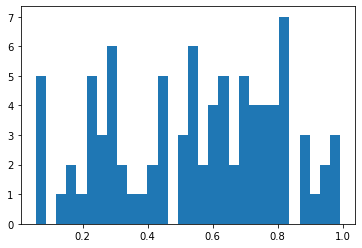

In [16]:
plt.hist(pvallist, bins=30)
plt.show()

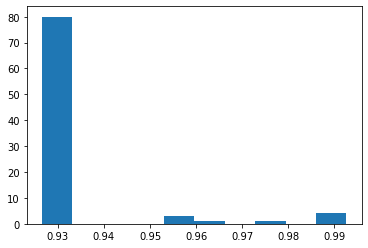

In [17]:
plt.hist(corrected_pvals)
plt.show()

## Differential oxPTM expression non-specific

Summedintensities optellen per modificatie, non-specifiek

In [18]:
summedintensities["UnimodAccession"] = summedintensities["Modifications"].apply(OA.get_unimod_acc)

In [19]:
test = summedintensities.groupby("UnimodAccession").sum().reset_index()

In [20]:
test.head()

,UnimodAccession,Gene Names,Organism,Intensity_1DLC0080815QE_RRAG_001_rep1,Intensity_1DLC0080815QE_RRAG_001_rep2,Intensity_1DLC120314QE_RRAG_001_rep1,Intensity_1DLC120314QE_RRAG_001_rep2,Intensity_1DLC012615QE_RRAG_001B_rep1,Intensity_1DLC012615QE_RRAG_001B_rep2,Intensity_1DLC012615QE_RRAG_001B_rep3,...,Intensity_1DLC120914QE_RRAG_009_rep1,Intensity_1DLC120914QE_RRAG_009_rep2,Intensity_1DLC120914QE_RRAG_009_rep3,Intensity_1DLC120914QE_RRAG_009_rep4,Intensity_1DLC012615QE_RRAG_009B_rep1,Intensity_1DLC012615QE_RRAG_009B_rep2,Intensity_1DLC012615QE_RRAG_009B_rep3,Intensity_1DLC012615QE_RRAG_009B_rep4,Unnamed: 983,Oxmod?
0,1384,0.0,0.0,34.249180,32.920773,63.853418,49.217222,107.871128,114.559158,23.390892,...,57.861357,30.487624,57.147464,65.002909,89.942908,64.533943,104.753674,65.807791,0.0,76
1,1914,0.0,0.0,179.541740,207.943624,361.475862,383.977329,428.409263,444.650228,176.758288,...,302.849126,311.968644,337.291333,382.418091,339.665902,358.311820,378.091515,362.566987,0.0,167
2,1915,0.0,0.0,148.698953,138.728676,304.134296,314.194732,303.902524,342.355520,93.578643,...,304.621795,337.853223,266.504594,331.345713,340.610515,313.447327,330.050479,316.462453,0.0,240
3,1916,0.0,0.0,24.467488,14.090657,59.701156,60.126112,71.692624,48.547605,0.000000,...,73.337904,82.074605,29.734345,23.754066,69.556311,42.190883,64.106895,48.109363,0.0,45
4,1917,0.0,0.0,9.140874,3.640351,20.393361,16.879295,25.428125,15.290130,0.000000,...,16.323924,16.209159,12.162728,15.216563,21.705387,11.673797,17.163885,15.260738,0.0,23


In [21]:
dict = {}
patientIDlist = []
patientIDBlist = []
for i in range(1,65):
    patientID = "_"+str(i).zfill(3)+"_"
    patientIDB = "_"+str(i).zfill(3)+"B_"
    patientIDlist.append(patientID)
    patientIDBlist.append(patientIDB)
for patient in patientIDlist:
    selected = test[[col for col in test if patient in col]]
    selected["UnimodAccession"] = test["UnimodAccession"]
    dict[patient] = selected
for patientB in patientIDBlist:
    selectedB = test[[col for col in test if patientB in col]]
    selected["UnimodAccession"] = test["UnimodAccession"]
    dict[patientB] = selectedB
    

In [22]:
for i in dict:
    df = dict[i]
    df["median"] = df.median(axis=1)

In [23]:
moddf = pd.DataFrame()
moddf["UnimodAccession"] = test["UnimodAccession"]
for patient in dict:
    moddf[patient] = dict[patient]["median"]

In [24]:
moddf = moddf.dropna(axis=1)
moddf.head()

,UnimodAccession,_001_,_002_,_003_,_004_,_005_,_006_,_007_,_008_,_009_,...,_053B_,_054B_,_055B_,_056B_,_058B_,_059B_,_060B_,_061B_,_062B_,_064B_
0,1384,49.217222,38.159778,57.823967,48.027800,104.736184,96.566377,71.108751,90.482660,57.861357,...,35.974134,24.149060,21.508536,31.149591,26.358303,27.402014,26.450183,32.712156,25.089600,28.827508
1,1914,361.475862,271.894099,333.482474,399.377580,452.270324,404.240725,351.269382,426.038687,337.291333,...,217.379047,128.293688,172.407446,172.499882,199.669614,174.612165,147.750055,196.263567,210.744476,232.879306
2,1915,304.134296,263.856080,301.464900,317.521842,331.169247,327.513479,284.365078,352.764738,331.345713,...,234.301806,163.027473,164.573487,160.188818,179.173018,170.959944,158.179475,150.566703,179.956174,155.202308
3,1916,59.701156,77.627342,57.787365,69.527089,71.996219,57.200786,54.362787,82.356095,73.337904,...,37.595112,36.557888,32.320174,43.518846,30.714903,18.235891,16.503262,25.490328,19.245598,36.223036
4,1917,16.879295,0.000000,20.039942,9.160355,15.268242,18.764260,17.835580,23.827445,16.209159,...,4.023550,0.000000,3.287131,4.629443,3.504710,3.657442,3.913355,2.370230,3.615960,0.000000


In [25]:
Healthydf = pd.DataFrame()
NonHealthydf = pd.DataFrame()
Healthydf["UnimodAccession"] = test["UnimodAccession"]
NonHealthydf["UnimodAccession"] = test["UnimodAccession"]
Healthy = [1,3,4,5,6,11,13,14,19,21,23,24,25,28,29,32,33,34,36,37,40,41,42,47,52,54,56,57,60,61,65]
NonHealthy = [2,7,9,10,12,15,17,18,20,22,26,27,30,31,35,38,39,43,44,45,46,48,49,50,51,53,55,58,59,62,63,64,8,16]
patienlist = []
patienBlist = []
for i in Healthy:
    patien = "_"+str(i).zfill(3)+"_"
    patienlist.append(patien)
    patienB = "_"+str(i).zfill(3)+"B_"
    patienBlist.append(patienB)

for i in patienlist:
    if i in moddf.columns:
        Healthydf[i] = moddf[i]
for i in patienBlist:
    if i in moddf.columns:
        Healthydf[i] = moddf[i]
    

In [26]:
NonHealthydf = pd.DataFrame()
patielist = []
patieBlist = []
NonHealthydf["UnimodAccession"] = test["UnimodAccession"]
for i in NonHealthy:
    patie = "_"+str(i).zfill(3)+"_"
    patielist.append(patie)
    patieB = "_"+str(i).zfill(3)+"B_"
    patieBlist.append(patieB)

for i in patielist:
    if i in moddf.columns:
        NonHealthydf[i] = moddf[i]
for i in patieBlist:
    if i in moddf.columns:
        NonHealthydf[i] = moddf[i]

In [27]:
OA.boxplots_not_specific(Healthydf, NonHealthydf, ["Healthy", "Non-Healthy"])

In [28]:
pvallist, corrected_pvals = OA.multipletest(Healthydf, NonHealthydf)

In [29]:
corrected_pvals

array([0.86031623, 0.86812389, 0.85285606, 0.85285606, 0.86812389,
       0.86812389, 0.86812389, 0.85285606, 0.85285606, 0.86031623,
       0.85285606, 0.86812389, 0.95299145, 0.86031623, 0.86812389,
       0.85285606, 0.85285606, 0.85285606, 0.85285606, 0.86812389,
       0.98614733, 0.86031623, 0.86031623, 0.85285606, 0.85285606,
       0.98614733, 0.85285606, 0.86812389, 0.85285606, 0.85285606,
       0.85285606, 0.86812389, 0.86812389, 0.86031623, 0.86812389,
       0.86812389, 0.85285606, 0.85285606, 0.85285606, 0.85285606,
       0.86812389, 0.85285606, 0.85285606, 0.86812389])

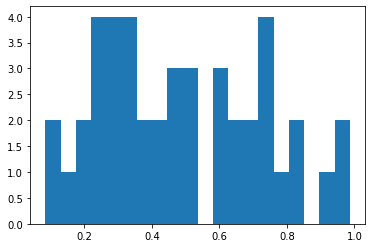

In [30]:
plt.hist(pvallist, bins = 20)
plt.show()

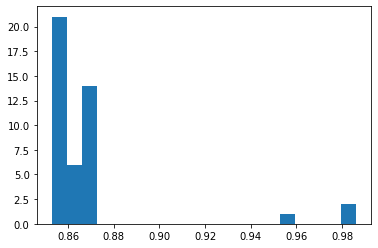

In [31]:
plt.hist(corrected_pvals, bins = 20)
plt.show()

## Distribution of methionine and cysteine oxidation status

In [32]:
Nonmodified = quant.loc[quant["Sequence"].str.endswith("nan") & quant["Base Sequence"].str.contains("M")]
Sulfoxide = quant.loc[quant["Sequence"].str.contains("[35]oxidation[M]",regex=False)]
Sulfone = quant.loc[quant["Sequence"].str.contains("[425]Dioxidation[M]", regex = False)]
Homocysteic_acid = quant.loc[quant["Sequence"].str.contains("[1384]Homocysteic_acid[M]", regex = False)]

In [33]:
Nonmodifiednums = Nonmodified.append(Nonmodified.sum(numeric_only=True), ignore_index=True)[-1:]
Sulfoxidenums = Sulfoxide.append(Sulfoxide.sum(numeric_only=True), ignore_index=True)[-1:]
Sulfonenums = Sulfone.append(Sulfone.sum(numeric_only=True), ignore_index=True)[-1:]
Homocysteicnums = Homocysteic_acid.append(Homocysteic_acid.sum(numeric_only=True), ignore_index= True)[-1:]
moddf = [Nonmodifiednums, Sulfoxidenums, Sulfonenums, Homocysteicnums]

In [34]:
Healthy = [1,3,4,5,6,11,13,14,19,21,23,24,25,28,29,32,33,34,36,37,40,41,42,47,52,54,56,57,60,61,65]
NonHealthy = [2,7,9,10,12,15,17,18,20,22,26,27,30,31,35,38,39,43,44,45,46,48,49,50,51,53,55,58,59,62,63,64,8,16]
Healthydict = {}
NonHealthydict = {}
for i in moddf:
    name = OA.retrieve_name(i)[1]
    df = i.filter(regex=r'_\d\d\d(?:B)?_')
    dfmeds = df.groupby(df.columns.str.extract(pat=r'(\d\d\d(?:B)?_)', expand=False),axis=1).median().add_prefix('med_')
    Healthysub = dfmeds.loc[:, dfmeds.columns.str.contains("|".join([str(i).zfill(2) for i in Healthy]))]
    NonHealthysub = dfmeds.loc[:, dfmeds.columns.str.contains("|".join([str(i).zfill(2) for i in NonHealthy]))]
    Healthysum = Healthysub.sum(axis=1)
    NonHealthysum = NonHealthysub.sum(axis=1)
    Healthydict[name] = Healthysum.values[0]
    NonHealthydict[name] = NonHealthysum.values[0]
    

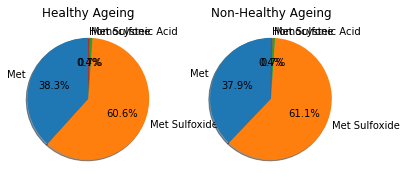

In [35]:
labels = ["Met", "Met Sulfoxide", "Met Sulfone", "Homocysteic Acid"]
sizesH = []
sizesNH = []
for x, y in Healthydict.items():
    if y != 0:
        sizesH.append(y)
for x, y in NonHealthydict.items():
    if y !=0:
        sizesNH.append(y)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.pie(sizesH, labels=labels, autopct='%1.1f%%', shadow= True, startangle = 90)
ax2.pie(sizesNH, labels=labels, autopct='%1.1f%%', shadow= True, startangle= 90)
plt.title("Methionine containing peptides")
ax1.set_title("Healthy Ageing")
ax2.set_title("Non-Healthy Ageing")

plt.show()

In [36]:
NonmodifiedC = quant.loc[quant["Sequence"].str.endswith("nan") & quant["Base Sequence"].str.contains("C")]
Sulfenic = quant.loc[quant["Sequence"].str.contains("[35]oxidation[C]",regex=False)]
Sulfinic = quant.loc[quant["Sequence"].str.contains("[425]Dioxidation[C]", regex = False)]
Cysteic = quant.loc[quant["Sequence"].str.contains("[345]Trioxidation[C]", regex = False)]

In [37]:
NonmodifiedCnums = NonmodifiedC.append(NonmodifiedC.sum(numeric_only=True), ignore_index=True)[-1:]
Sulfenicnums = Sulfenic.append(Sulfenic.sum(numeric_only=True), ignore_index=True)[-1:]
Sulfinicnums = Sulfinic.append(Sulfinic.sum(numeric_only=True), ignore_index=True)[-1:]
Cysteicnums = Cysteic.append(Cysteic.sum(numeric_only=True), ignore_index=True)[-1:]
moddf = [NonmodifiedCnums, Sulfenicnums, Sulfinicnums, Cysteicnums]

In [38]:
Healthy = [1,3,4,5,6,11,13,14,19,21,23,24,25,28,29,32,33,34,36,37,40,41,42,47,52,54,56,57,60,61,65]
NonHealthy = [2,7,9,10,12,15,17,18,20,22,26,27,30,31,35,38,39,43,44,45,46,48,49,50,51,53,55,58,59,62,63,64,8,16]
Healthydict = {}
NonHealthydict = {}
for i in moddf:
    name = OA.retrieve_name(i)[1]
    df = i.filter(regex=r'_\d\d\d(?:B)?_')
    dfmeds = df.groupby(df.columns.str.extract(pat=r'(\d\d\d(?:B)?_)', expand=False),axis=1).median().add_prefix('med_')
    Healthysub = dfmeds.loc[:, dfmeds.columns.str.contains("|".join([str(i).zfill(2) for i in Healthy]))]
    NonHealthysub = dfmeds.loc[:, dfmeds.columns.str.contains("|".join([str(i).zfill(2) for i in NonHealthy]))]
    Healthysum = Healthysub.sum(axis=1)
    NonHealthysum = NonHealthysub.sum(axis=1)
    Healthydict[name] = Healthysum.values[0]
    NonHealthydict[name] = NonHealthysum.values[0]

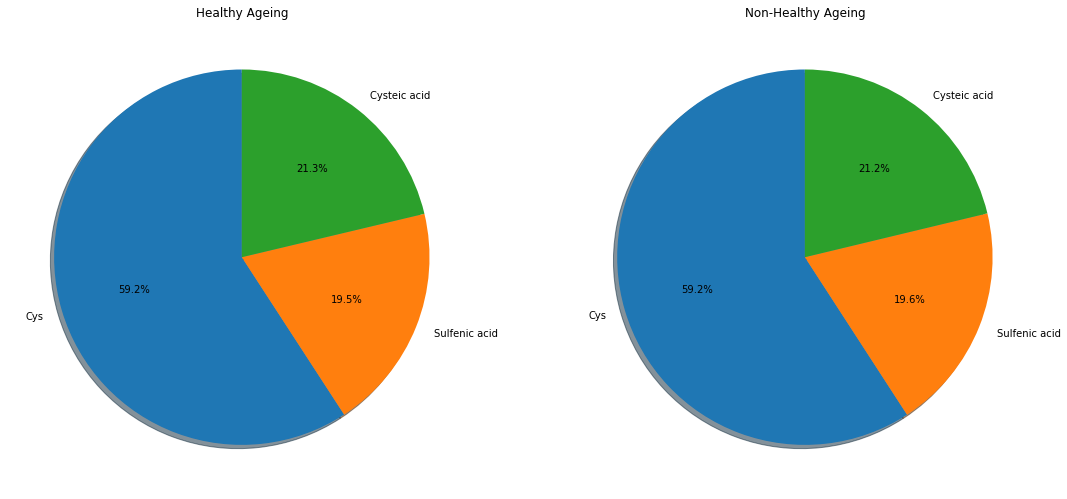

In [39]:
labels = ["Cys", "Sulfenic acid", "Cysteic acid"]
sizesH = []
sizesNH = []
for x, y in Healthydict.items():
    if y != 0:
        sizesH.append(y)
for x, y in NonHealthydict.items():
    if y != 0:
        sizesNH.append(y)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.pie(sizesH, labels=labels, autopct='%1.1f%%', shadow= True, startangle = 90)
ax2.pie(sizesNH, labels=labels, autopct='%1.1f%%', shadow= True, startangle= 90)
ax1.set_title("Healthy Ageing")
ax2.set_title("Non-Healthy Ageing")
fig.set_size_inches(18.5, 10.5)
plt.show()